Google Colab Jupyter notebook - https://colab.research.google.com/drive/14xWLWcEjYAHfv4SHZ0vIlodpU6VtXCPd
<br>
<br>
<b>Sensor data classification - Gradient Boosting vs. Neural Network models </b>

Inspired by the paper "Human activity recognition based on time series analysis using U-Net" by Yong Zhang,  Yu Zhang et.al (https://arxiv.org/ftp/arxiv/papers/1809/1809.08113.pdf), decided to do my own version of this experiment to find out performance differences between high performer from Gradient Boosting camp aka XGBOOST vs. Neural Network models. 

Dataset is from https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones#
<br>
<br>
From Dataset description:<br>
The experiments have been carried out with a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope, we captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz. The experiments have been video-recorded to label the data manually. The obtained dataset has been randomly partitioned into two sets, where 70% of the volunteers was selected for generating the training data and 30% the test data.

In [0]:
!pip install --upgrade tensorflow

In [1]:
import tensorflow as tf
tf.__version__

'2.0.0'

In [0]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, f1_score, recall_score, precision_score, accuracy_score
from sklearn.model_selection import cross_validate

import pandas_profiling as pp
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import losses

from tensorflow.keras.callbacks import ModelCheckpoint
!pip install -q h5py pyyaml

# Load the Data

In [4]:
from google.colab import drive
drive.mount('/gdrive')


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
from pathlib import Path

data_folder_train = Path("/gdrive/My Drive/Colab Notebooks/HAR_Dataset/train")
data_folder_test = Path("/gdrive/My Drive/Colab Notebooks/HAR_Dataset/test")

train_data = data_folder_train / "X_train.txt"
train_label_file = data_folder_train / "y_train.txt"
test_data = data_folder_test / "X_test.txt"
test_label_file = data_folder_test / "y_test.txt"


def get_datasets():
  #Offsetting labels by -1, as this is required by neural networks
  
  X_train = pd.read_csv(train_data, header=None, sep='\s+')
  y_train = pd.read_csv(train_label_file, header=None)-1
  X_test = pd.read_csv(test_data, header=None, sep='\s+')
  y_test = pd.read_csv(test_label_file, header=None)-1
  return X_train, y_train, X_test, y_test

In [0]:
X_train, y_train, X_test, y_test = get_datasets()

In [5]:
y_train[0].value_counts()

5    1407
4    1374
3    1286
0    1226
1    1073
2     986
Name: 0, dtype: int64

In [6]:
X_test.head(10)

0         1         2    ...       558       559       560
0  0.257178 -0.023285 -0.014654  ... -0.720009  0.276801 -0.057978
1  0.286027 -0.013163 -0.119083  ... -0.698091  0.281343 -0.083898
2  0.275485 -0.026050 -0.118152  ... -0.702771  0.280083 -0.079346
3  0.270298 -0.032614 -0.117520  ... -0.698954  0.284114 -0.077108
4  0.274833 -0.027848 -0.129527  ... -0.692245  0.290722 -0.073857
5  0.279220 -0.018620 -0.113902  ... -0.689816  0.294896 -0.068471
6  0.279746 -0.018271 -0.104000  ... -0.690085  0.295282 -0.067065
7  0.274601 -0.025035 -0.116831  ... -0.688785  0.295981 -0.067706
8  0.272529 -0.020954 -0.114472  ... -0.685390  0.299394 -0.065491
9  0.275746 -0.010372 -0.099776  ... -0.684110  0.300822 -0.064263

[10 rows x 561 columns]

In [7]:
y_train[0].value_counts()

5    1407
4    1374
3    1286
0    1226
1    1073
2     986
Name: 0, dtype: int64

In [8]:
y_test[0].value_counts()

5    537
4    532
0    496
3    491
1    471
2    420
Name: 0, dtype: int64

# Inspect X_train part

In [0]:
# Not showing as you have to scroll through every 561 feature report on GitLab.

pp.ProfileReport(X_train)

# Data Cleaning

There are so many highly correlated features. Dropping features that have >0.95 correlation

In [0]:
def remove_correlated(train, test):
  corr_matrix = train.corr().abs()

  # Select upper triangle of correlation matrix
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  # Find index of feature columns with correlation greater than 0.95
  to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

  print("{} features were dropped".format(len(to_drop)))

  train.drop(train[to_drop], axis=1, inplace=True)
  test.drop(test[to_drop], axis=1, inplace=True)


In [10]:
remove_correlated(X_train, X_test)

X_train.shape, X_test.shape

308 features were dropped


((7352, 253), (2947, 253))

# Visualisation

Let's try to look in to the different patterns between target groups.

There are still way too many columns to visualise, so taking only 2nd and 3rd columns and checking sensor values for each label. 6 plots, each for different acitivity label.

In [11]:
df = X_train.copy()
df["labels"] = y_train

df.shape

(7352, 254)

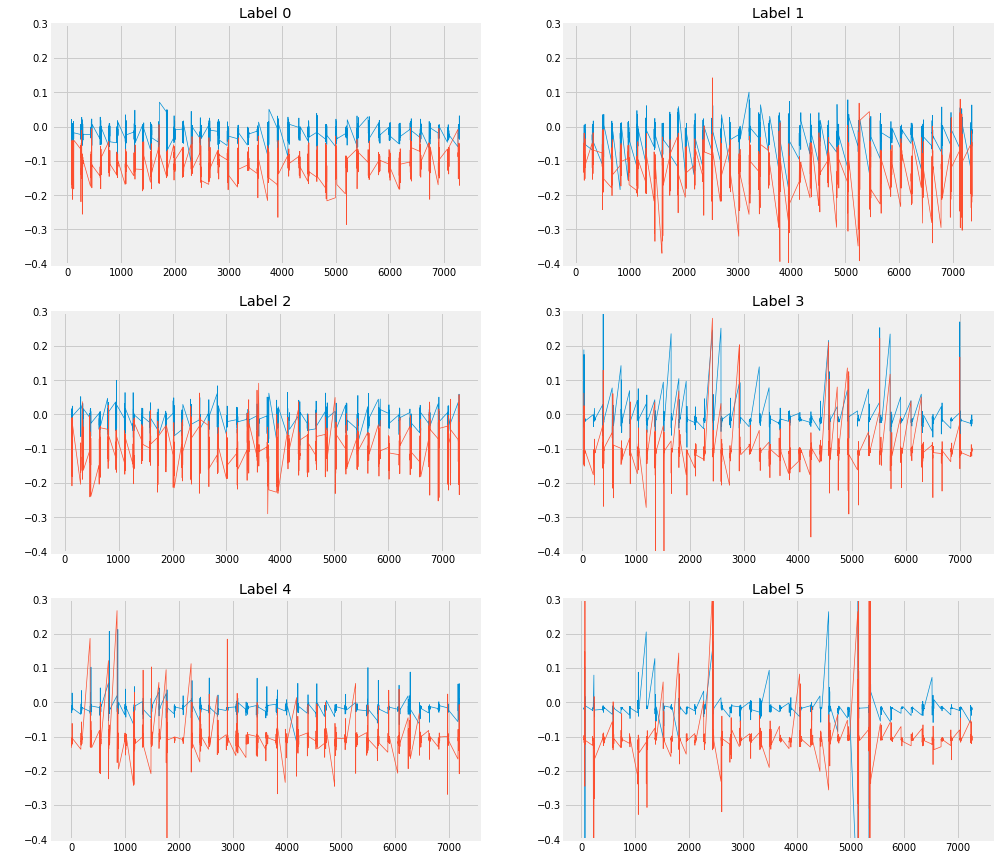

In [12]:
fig, axes = plt.subplots(3,2, figsize=(15,15), gridspec_kw={'wspace': 0.2})

for pos, label in enumerate(range(0,y_train[0].nunique())):
  sns.lineplot(y=df.loc[df["labels"]==label][1], x=df.loc[df["labels"]==label].index, ax=axes.flatten()[pos], lw=0.7).set_title("Label {}".format(label))
  sns.lineplot(y=df.loc[df["labels"]==label][2], x=df.loc[df["labels"]==label].index, ax=axes.flatten()[pos], lw=0.7).set_ylabel(" ")
  ax=axes.flatten()[pos].set_ylim(-.4, .3)


<br>
<br>

It is easy to see how activities look different from each other, so there should be no problem for algorithms to learn and have a good accuracy.
<br>
<br>
<br>
<br>

# Modeling
<br>
Accuracy will be used as a performance metric across the all models to see how well the model is performing during training phase.<br>
<br>
For XGBOOST scikit-learn CrossValidation will be used.<br>
For NN models validation_split=0.2 will be used in the .fit() phase.
<br>
<br>


## XGBoost Classifier

In [0]:
# Function to run CrossValidation and check model's performance over the training dataset.

def run_CV(model_name):

    scores = cross_validate(model_name, X_train.values, y_train.values.ravel(), 
                             scoring='accuracy', cv=5)
    
    print('Accuracy mean is {}'.format(str(np.mean(scores['test_score']))))


In [14]:
from xgboost import XGBClassifier

xgb = XGBClassifier(objective = "multi:softprob", num_class=6, gpu_id=0, tree_method = "gpu_hist")

run_CV(xgb)


Accuracy mean is 0.9258909926563585


## Simple NN model

Building 1 hidden layer Neural Network, with Softmax activation for multiclass probability output. Loss function is sparse_categorical_crossentropy, which does not require one hot encoding for y_train values.



### Data preparation

In [15]:
n_features, n_outputs = X_train.shape[1], y_train.nunique().values[0]
n_features, n_outputs

(253, 6)

In [0]:
X_train = X_train.values
y_train = y_train.values

### Modeling NN

In [0]:
filepath='../gdrive/My Drive/Colab Notebooks/HAR_Dataset/weights-improvement-{val_accuracy:.3f}.hdf5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath, verbose=1, save_best_only=True, mode='auto', monitor="val_accuracy")
callbacks_list = [cp_callback]

In [0]:
# tf.keras.backend.clear_session()

In [18]:
# Using 'sparse_categorical_crossentropy' loss, which does not require to one hot encode y_train

classifier = Sequential()
classifier.add(Dense(100, activation='relu', kernel_initializer='random_normal', input_dim=n_features))
classifier.add(Dropout(0.3))
classifier.add(Dense(n_outputs, activation='softmax'))                
classifier.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

verbose, epochs, batch_size = 1, 50, 16
# fit network
history = classifier.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=callbacks_list, validation_split=0.2)



Train on 5881 samples, validate on 1471 samples
Epoch 1/50
5488/5881 [==========================>...] - ETA: 0s - loss: 0.7103 - accuracy: 0.7281
Epoch 00001: val_accuracy improved from -inf to 0.90007, saving model to ../gdrive/My Drive/Colab Notebooks/HAR_Dataset/weights-improvement-0.900.hdf5
5881/5881 [==============================] - 1s 244us/sample - loss: 0.6884 - accuracy: 0.7373 - val_loss: 0.2931 - val_accuracy: 0.9001
Epoch 2/50
5504/5881 [===========================>..] - ETA: 0s - loss: 0.2694 - accuracy: 0.9059
Epoch 00002: val_accuracy improved from 0.90007 to 0.93134, saving model to ../gdrive/My Drive/Colab Notebooks/HAR_Dataset/weights-improvement-0.931.hdf5
5881/5881 [==============================] - 1s 172us/sample - loss: 0.2651 - accuracy: 0.9075 - val_loss: 0.1797 - val_accuracy: 0.9313
Epoch 3/50
5456/5881 [==========================>...] - ETA: 0s - loss: 0.1907 - accuracy: 0.9315
Epoch 00003: val_accuracy improved from 0.93134 to 0.94154, saving model to ../

<br>
Validation accuracy settled at ~0.945, a bit better than XGBOOST.
<br>
<br>

## LSTM Model

In this part I am going to look if there is an advantage in using LSTM's Many-to-Many feature, where a sequence of 10 rows from X_train and y_train will be feeded at once.


### Data Preparation


In [19]:
# Start with a clean data

X_train, y_train, X_test, y_test = get_datasets()
remove_correlated(X_train, X_test)

308 features were dropped


In [0]:
"""
Cutting data a bit short(-2 rows from 7352), to make the number easily divisible by 10 
and have a full array to feed in to the LSTM.

Reshaping input to 3D format that is needed for LSTM
(number of samples, time-step size per 1 sample, features)

"""

X_train = X_train[0:7350].to_numpy()
y_train= y_train[0:7350].to_numpy()

X_train = X_train.reshape(735, 10, 253)
y_train = y_train.reshape(735, 10)


In [21]:
X_train.shape, y_train.shape

((735, 10, 253), (735, 10))

In [22]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], len(np.unique(y_train))
n_timesteps, n_features, n_outputs

(10, 253, 6)

### Modeling

In [0]:
tf.keras.backend.clear_session()

In [24]:
filepath='../gdrive/My Drive/Colab Notebooks/HAR_Dataset/weights-LSTM-{val_acc:.3f}.hdf5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath, verbose=1, save_best_only=True, mode='auto', monitor="val_acc")
callbacks_list = [cp_callback]

model2 = Sequential()
model2.add(LSTM(100, input_shape=(n_timesteps,n_features), return_sequences=True))
model2.add(Dropout(0.3))
model2.add(Dense(100, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(n_outputs, activation='softmax'))
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

verbose, epochs, batch_size = 1, 50, 8
# fit network
history = model2.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=callbacks_list, validation_split=0.2)


Train on 588 samples, validate on 147 samples
Epoch 1/50
560/588 [===========================>..] - ETA: 0s - loss: 1.1058 - acc: 0.5489
Epoch 00001: val_acc improved from -inf to 0.86395, saving model to ../gdrive/My Drive/Colab Notebooks/HAR_Dataset/weights-LSTM-0.864.hdf5
588/588 [==============================] - 4s 6ms/sample - loss: 1.0920 - acc: 0.5565 - val_loss: 0.5173 - val_acc: 0.8639
Epoch 2/50
568/588 [===========================>..] - ETA: 0s - loss: 0.5401 - acc: 0.7975
Epoch 00002: val_acc did not improve from 0.86395
588/588 [==============================] - 1s 2ms/sample - loss: 0.5320 - acc: 0.8015 - val_loss: 0.3839 - val_acc: 0.8585
Epoch 3/50
560/588 [===========================>..] - ETA: 0s - loss: 0.3490 - acc: 0.8718
Epoch 00003: val_acc improved from 0.86395 to 0.87687, saving model to ../gdrive/My Drive/Colab Notebooks/HAR_Dataset/weights-LSTM-0.877.hdf5
588/588 [==============================] - 1s 2ms/sample - loss: 0.3499 - acc: 0.8713 - val_loss: 0.3220

# Evaluate models with test dataset

<br>
All 3 of them showed very good results, with accuracy reaching 92-95% on training set. How they are going to perform on test data, does LSTM still be able to retain ~3% better accuracy?
<br>
<br>

In [0]:
def get_report(y_test, y_pred):

    print(classification_report(y_test, y_pred))
    
    confusion = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(confusion, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
    sns.set(font_scale=0.9)
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');

In [26]:
# Start with a clean data

X_train, y_train, X_test, y_test = get_datasets()
remove_correlated(X_train, X_test)

308 features were dropped


## XGBOOST evaluation

In [0]:
def run_model(name):
    name.fit(X_train.values, y_train.values.ravel())
    y_pred = name.predict(X_test.values)

    print(classification_report(y_test, y_pred))
    
    confusion = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(confusion, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r',);
    sns.set(font_scale=0.9)
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');

              precision    recall  f1-score   support

           0       0.92      0.99      0.96       496
           1       0.92      0.91      0.91       471
           2       0.97      0.90      0.93       420
           3       0.92      0.87      0.89       491
           4       0.89      0.93      0.91       532
           5       1.00      1.00      1.00       537

    accuracy                           0.94      2947
   macro avg       0.94      0.93      0.93      2947
weighted avg       0.94      0.94      0.94      2947



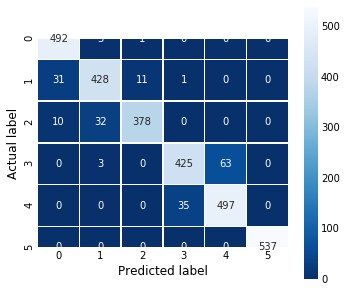

In [28]:
# Run XGBOOST with the same parameters as in training phase.

xgb = XGBClassifier(objective = "multi:softprob", num_class=6, gpu_id=0, tree_method = "gpu_hist")

run_model(xgb)

## Simple NN evaluation

In [0]:
classifier.load_weights("../gdrive/My Drive/Colab Notebooks/HAR_Dataset/weights-improvement-0.959.hdf5")

In [0]:
y_pred_NN = classifier.predict_classes(X_test.values)

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       496
           1       0.95      0.90      0.92       471
           2       0.94      0.96      0.95       420
           3       0.93      0.88      0.91       491
           4       0.86      0.94      0.90       532
           5       1.00      0.96      0.98       537

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947



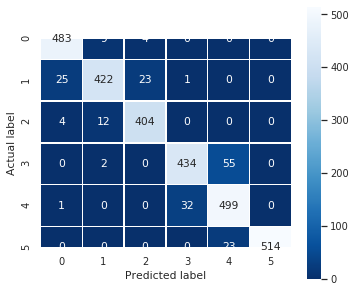

In [34]:
get_report(y_test, y_pred_NN)

## LSTM evaluation

In [0]:
# LSTM test data preparation

X_test_lstm = X_test.copy()
y_test_lstm = y_test.copy()

X_test_lstm = X_test_lstm[0:2940].to_numpy()
y_test_lstm = y_test_lstm[0:2940].to_numpy()

X_test_lstm = X_test_lstm.reshape(294, 10, 253)
y_test_lstm = y_test_lstm.reshape(294, 10)

In [0]:
model2.load_weights('../gdrive/My Drive/Colab Notebooks/HAR_Dataset/weights-LSTM-0.961.hdf5')

y_pred_LSTM = model2.predict_classes(X_test_lstm)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       496
           1       0.94      0.93      0.93       464
           2       0.96      0.93      0.95       420
           3       0.93      0.91      0.92       491
           4       0.92      0.94      0.93       532
           5       1.00      1.00      1.00       537

    accuracy                           0.95      2940
   macro avg       0.95      0.95      0.95      2940
weighted avg       0.95      0.95      0.95      2940



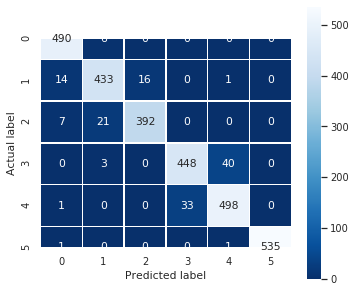

In [37]:
get_report(y_test[0:2940], y_pred_LSTM.flatten())

# Conclusions


*   XGBOOST proves its capabilities to classify sensor data without any parameter tuning by returning high accuracy on test data.
*   During model building phase Neural Networks showed their tendency to overfit on training set, but the end result is really good with LSTM and possibly could be better with further experimentation with its architecture and parameters.

